In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow import *
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Integer, Categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.utils.np_utils import to_categorical
import datetime
from keras.callbacks import TensorBoard, ModelCheckpoint
from skopt import callbacks
from skopt.callbacks import CheckpointSaver
from tensorflow.python.client import device_lib
import pandas as pd
import gc
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from skopt.plots import plot_objective_2D
import time
from skopt import load
from keras.applications.efficientnet import preprocess_input
from tensorflow.keras import mixed_precision
import os

In [2]:
### zmiejszoby rozmiar, dla ułatwienia obliczeń (mniejsze zuzycie GPU)

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory('./data/', 
                                                           label_mode = None, image_size = (128, 128), batch_size = 8)
data = data.map(lambda x: x / 255.0)

Found 300 files belonging to 1 classes.


In [14]:
def Generator():
    model = tf.keras.Sequential()
    model.add(Dense(16*16*128,activation="relu",input_dim=256))  #256
    model.add(Reshape((16,16,128)))
    model.add(Conv2D(512,(3,3),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(512,(3,3),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256,(5,5),padding="same",activation="relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(3,(5,5),padding="same"))
    model.add(Activation("tanh"))
    return model

In [7]:
keras.backend.clear_session()
generator = Generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 131072)            16908288  
                                                                 
 reshape (Reshape)           (None, 16, 16, 512)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 512)       2359808   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 512)       2359808   
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 512)       2359808   
                                                        

(-0.5, 127.5, 127.5, -0.5)

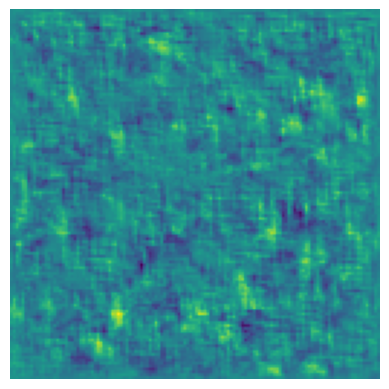

In [6]:
generator = Generator()
#Creating a random seed and output from generator
seed = tf.random.normal([1, 256])
generated_image = generator(seed, training=False)
#Plotting the image output of generator without training 
plt.imshow(generated_image[0, :, :, 0])
plt.axis("off")

In [ ]:
generated_image.shape

In [5]:
def Discrimiator():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (7,7), padding='same',
                                     input_shape=[128,128, 3]))
    model.add(Conv2D(64, (7,7),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (5,5),  padding='same'))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (5,5),  padding='same'))
    model.add(Conv2D(128, (3,3),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3),  padding='same'))
    model.add(Conv2D(128, (3,3),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(Conv2D(512, (3,3),  padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(512, (3,3), padding='same'))
    model.add(Conv2D(512, (3,3),  padding='same'))    
    model.add(GlobalMaxPooling2D())
    model.add(Flatten())
    model.add(Dense(256,activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="softmax"))

    return model

In [11]:
keras.backend.clear_session()
discriminator = Discrimiator()
discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      9472      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      200768    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       2

In [15]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        self.discriminator_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.generator_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(seed)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.discriminator_loss_metric.update_state(d_loss)
        self.generator_loss_metric.update_state(g_loss)
        return {"discriminator_loss": self.discriminator_loss_metric.result(), "generator_loss": self.generator_loss_metric.result()}

In [18]:
keras.backend.clear_session()
generator = Generator()
discriminator = Discrimiator()
epochs = 200
model = GAN(discriminator=discriminator, generator=generator, latent_dim=256)

model.compile(tf.keras.optimizers.Adam(1.5e-5,0.5), tf.keras.optimizers.Adam(1.5e-5,0.5), loss_fn=tf.keras.losses.BinaryCrossentropy())

history = model.fit(data, epochs=epochs)

Epoch 1/200
38/38 [==============================] - 21s 506ms/step - discriminator_loss: 0.6265 - generator_loss: 0.6554
Epoch 2/200
38/38 [==============================] - 19s 509ms/step - discriminator_loss: 0.4925 - generator_loss: 0.7160
Epoch 3/200
38/38 [==============================] - 19s 509ms/step - discriminator_loss: 0.5402 - generator_loss: 0.6554
Epoch 4/200
38/38 [==============================] - 19s 512ms/step - discriminator_loss: 0.6440 - generator_loss: 0.6704
Epoch 5/200
38/38 [==============================] - 19s 512ms/step - discriminator_loss: 0.6072 - generator_loss: 0.8200
Epoch 6/200
38/38 [==============================] - 20s 515ms/step - discriminator_loss: 0.4672 - generator_loss: 1.0700
Epoch 7/200
38/38 [==============================] - 20s 516ms/step - discriminator_loss: 0.2103 - generator_loss: 1.3524
Epoch 8/200
38/38 [==============================] - 20s 515ms/step - discriminator_loss: 0.4301 - generator_loss: 2.2776
Epoch 9/200
38/38 [=====

38/38 [==============================] - 20s 525ms/step - discriminator_loss: 0.4127 - generator_loss: 1.6683
Epoch 68/200
38/38 [==============================] - 20s 525ms/step - discriminator_loss: 0.3199 - generator_loss: 1.7155
Epoch 69/200
38/38 [==============================] - 20s 525ms/step - discriminator_loss: 0.3594 - generator_loss: 1.8028
Epoch 70/200
38/38 [==============================] - 20s 523ms/step - discriminator_loss: 0.1767 - generator_loss: 2.0937
Epoch 71/200
38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.4556 - generator_loss: 1.8752
Epoch 72/200
38/38 [==============================] - 20s 528ms/step - discriminator_loss: 0.4613 - generator_loss: 1.8966
Epoch 73/200
38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.4314 - generator_loss: 2.0333
Epoch 74/200
38/38 [==============================] - 20s 523ms/step - discriminator_loss: 0.2779 - generator_loss: 1.7068
Epoch 75/200
38/38 [=========

38/38 [==============================] - 20s 526ms/step - discriminator_loss: 0.2312 - generator_loss: 2.5248
Epoch 134/200
38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.2368 - generator_loss: 2.5690
Epoch 135/200
38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.2662 - generator_loss: 2.5551
Epoch 136/200
38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.2074 - generator_loss: 2.6376
Epoch 137/200
38/38 [==============================] - 20s 529ms/step - discriminator_loss: 0.2283 - generator_loss: 2.5302
Epoch 138/200
38/38 [==============================] - 20s 525ms/step - discriminator_loss: 0.2135 - generator_loss: 2.5307
Epoch 139/200
38/38 [==============================] - 20s 528ms/step - discriminator_loss: 0.2222 - generator_loss: 3.0184
Epoch 140/200
38/38 [==============================] - 20s 527ms/step - discriminator_loss: 0.1461 - generator_loss: 4.1814
Epoch 141/200
38/38 [=

38/38 [==============================] - 20s 524ms/step - discriminator_loss: 0.0940 - generator_loss: 4.3196
Epoch 200/200
38/38 [==============================] - 20s 525ms/step - discriminator_loss: 0.1050 - generator_loss: 4.5990


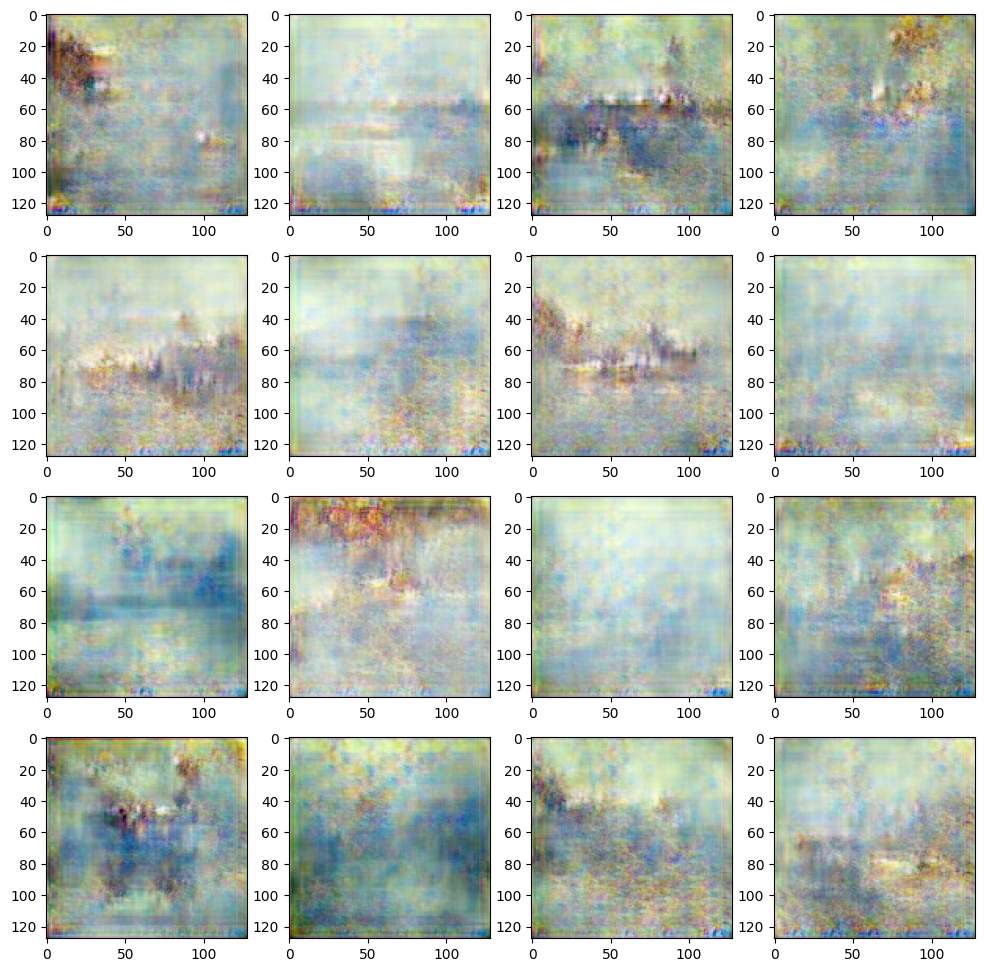

In [19]:
generated_images = []
for i in range(0, 16):
    seed = tf.random.normal([1, 256])
    generated_image = generator(seed, training=False)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    img = tf.keras.preprocessing.image.array_to_img(generated_image[0])
    generated_images.append(img)
    
_, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(generated_images, axs):
    ax.imshow(img)
